# Peeking Inside a Neural Network

Welcome to the second part of the parctical section of module 5.4 on neural networks. In this part we'll try to take a peek inside a neural network and see how it handles the data. We won't probably be able to understand anything of the internals of the network, but we might get an intution about how it works. We'll train our neural network on the [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/): one of the most widely used datasets in image processing and machine learning. The dataset consists of a number of 28x28 images and their corresponding labels. Each image is a handwritten digit and the label is the value of that digit in the image. We'll train our network to classify these images, i.e. to recognize the digits in the image, then we'll delve inside the network and try to see what's going on!

As noted before in the first part, the current stable version of scikit-learn doesn't provide any APIs for neural networks, so we'll be using the third-party library [scikit-neuralnetwork](https://scikit-neuralnetwork.readthedocs.io/en/latest/).

In [52]:
import pandas as pd
import numpy as np
from sknn.mlp import Classifier, Layer
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = (10, 10)

# Preparing the data

To save us a lot of headache of downloading the images of the MNIST dataset and loading the images into memory to build the dataset, we'll use one of scikit-learn's builtin method in the **datasets** package to automatically retrieve the dataset and load it into memory; this is the **fetch_mldata** method. This method retrieves by name a dataset from the [mldata.org](http://mldata.org/) data repository.

In [2]:
# you may have to wait a bit for the data to be downlaoded
mnist = fetch_mldata("MNIST original")

print "Data min. value: %d" % (mnist.data.min())
print "Data max. value: %d" % (mnist.data.max())
print "Data instance size: %d" % (mnist.data.shape[1])

Data min. value: 0
Data max. value: 255
Data instance size: 784


We can see that the values of the pixels are between 0 and 255. To have an effcient training experince, we should scale the data to be between 0 and 1. This is a classic case of **feature sacling** which would make the training process faster. In this case we do not need a sophistacted scalar like we used before, all we need to do is to divide the data by 255.0.

In [3]:
X, y = mnist.data / 255., mnist.target

print "Data min. value: %.2f" % (X.min())
print "Data max. value: %.2f" % (X.max())

Data min. value: 0.00
Data max. value: 1.00


Now we can view some of the images to see what we're dealing with here. We can show an image from the raw pixel data using **metaplotlib**'s method **matshow** which takes a matrix and dispalys it as image. Note that each image is represented as a flat 1D array of size 784, we'll need to reshape it to a 2D 28x28 array to be able to display it.

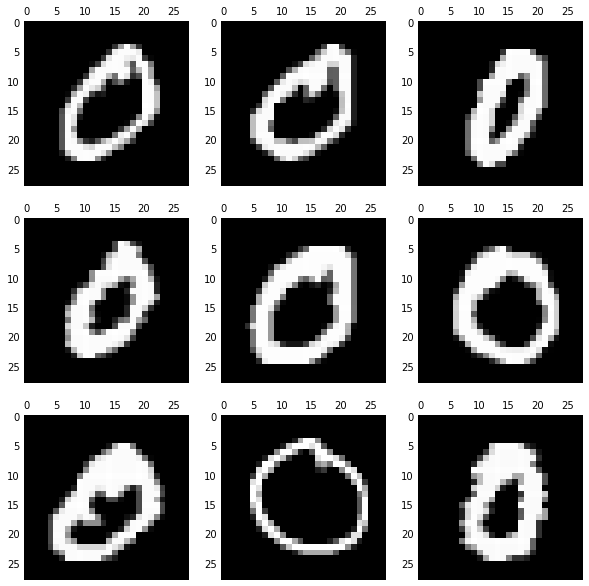

In [4]:
instances = X[0:9]
instances = instances.reshape(-1, 28, 28)

# here we create a 3x3 grid of figures (9 plots)
fig, axes = plt.subplots(3, 3)
axes = axes.ravel()  # flat the 3x3 array of references to plots into a 1d array of size 9

for i,instance in enumerate(instances):
    axes[i].matshow(instance, cmap=cm.gray)
plt.show()

For this visulaization of the first 9 images, it appears that the data is ordered by the value of the digit. This ordering might result in a biased test set, so we need to shuffle the data to ensure statsically unbiased sets.

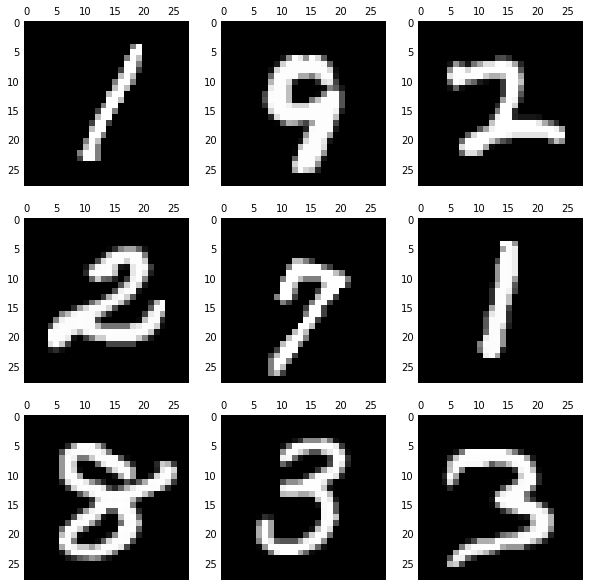

In [5]:
# random_state is a seed value to enure we get the same shuffling each run
X, y = shuffle(X, y, random_state=0)

instances = X[0:9]
instances = instances.reshape(-1, 28, 28)

# here we create a 3x3 grid of figures (9 plots)
fig, axes = plt.subplots(3, 3)
axes = axes.ravel()  # flat the 3x3 array of references to plots into a 1d array of size 9

for i,instance in enumerate(instances):
    axes[i].matshow(instance, cmap=cm.gray)
plt.show()

Now the data is shuffled, and due to the shuffling we also got to take a diverse look at the data images. Now we're one step away from building our neural network, we just need to split our dataset into training and testing parts and we're ready!

In [6]:
dataset_size = X.shape[0]
train_size = np.floor(dataset_size * 0.7).astype(int)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Building and Training the Neural Network

In the same way described in the previous part, we'll build a small neural network with one hidden layer of 64 neurons, and one softmax output layer. We're keeping it small to be able to peek inside it later and visualize the weights and try to get an intution of what they do.

In [94]:
# the use of batch_size in the following specifies that instead of
# training the network on all the data instances every iteration
# we train on a random sample of size 128 from the data
# this is called stochastic gradient descent (SGD) and it's much faster
# than the regular gradient descent without much loss in accuracy
nn = Classifier(
    layers = [
        Layer("Rectifier", units=64),
        Layer("Softmax")
    ],
    verbose = True,
    n_iter=100,
    random_state=1,
    batch_size=128
)

# This may take some time, be patient!
nn.fit(X_train, y_train)

Classifier(batch_size=128, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=64, name=u'hidden0', frozen=False>,
      layers=[<sknn.nn.Layer `Rectifier`: units=64, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Softmax`: units=10, name=u'output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.01, learning_rule=u'sgd',
      loss_type=None, n_iter=100, n_stable=10, normalize=None,
      output=<sknn.nn.Layer `Softmax`: units=10, name=u'output', frozen=False>,
      parameters=None, random_state=1, regularize=None, valid_set=None,
      valid_size=0.0, verbose=True, warning=None, weight_decay=None)

Now we evaluate our model's accuracy using the mean accuracy metric:
$$\frac{1}{n}\sum_{i = 1}^{n} 1(y_i = \widehat{y_i}) \hspace{0.5em} \text{where } \widehat{y_i} \text{ is the predecited value}$$

$$,1(P) = 
\left\{
\begin{matrix}
1 \hspace{1.5em} \text{if } P \text{ is true}\\
0 \hspace{1.5em} \text{otherwise}
\end{matrix}
\right.$$
We'll see that the model is pretty accurate and we didn't lose much with using SGD.

In [95]:
predections = nn.predict(X_train)
predections = predections.reshape((-1,))

mean_accuracy = np.mean(predections == y_train)

print "Mean Accuracy: %.2f" % (mean_accuracy)

[(49000, 10)]
Mean Accuracy: 0.97


# Peeking Inside The Network

Now we attempt to take a look inside the network and see what it's doing to the inputs. Our first step is to visualize the weigths of each layer and the transformation they perform on an input data.

The hidden layer has 64 neuron and takes as input our flat data image of size 784. So the weigths of the first layer is 784x64 matrix, or a 28x28x64 *rank-3 tesnor* (you can think of a **rank-k tensor** as a multidimensional array of k dimensions. A matrix is a rank-2 tensor). We then visualize each neuron weights as a 28x28 image just as we did with the input images.

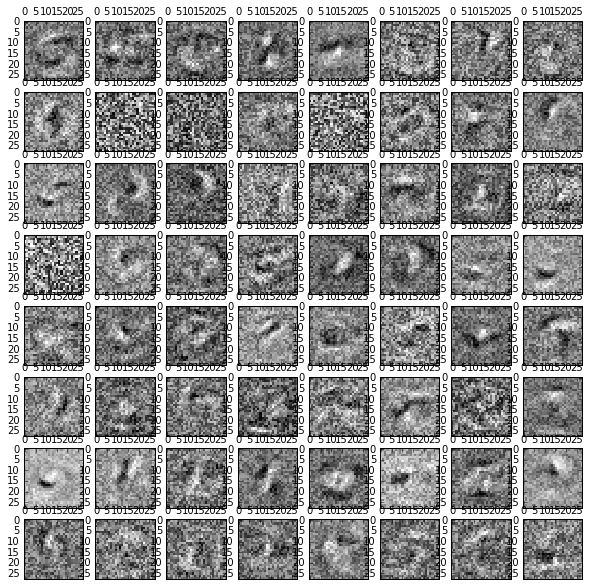

In [96]:
hidden0 = nn.get_parameters()[0][0]
vmin, vmax = hidden0.min(), hidden0.max()

fig, axes = plt.subplots(8, 8)
axes = axes.ravel()

for i, axis in enumerate(axes):
    weights = hidden0[:,i].reshape(28, 28)
    axis.matshow(weights, cmap=cm.gray)
    
plt.show()

This looks like a useless bunch of static, but if we looked carefully at the visualization of the weights we'll be able to see some **spatial structures (dents and bulges)** in the static. What do these spatial structure represent? I have no clue! But it seems that the weigths act as filters on the input image to retrieve some spatial charactaristics that helps in defining each class. 

This gives us a general intution about how neural networks work: as the input propagates through the layers, the network learns and exatracts relevant, and very complex and nonlinear, features that aid in identifying the data instnace at question. The more the hidden, the richer and the more complicated features learned and extracted form the input, the more accurate is the performance of the network.